In [1]:
# Inception  - Visual-explanations - Gradcam  Gradcam++   Hyperparameters tuning with all layers training - Accuracy

##  Inception - Visual-explanations- Gradcam | Gradcam++   

### Import libraries.

In [6]:
import copy
import os
import warnings
warnings.filterwarnings('ignore')

import cv2
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import shap
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(123)

### Loading Datasets

In [54]:
path = os.path.join('D:\\FYP\Datasets\\', 'TotalNvAndMelNoDuplicatesFullSize_244.zip')
path

'D:\\FYP\\Datasets\\TotalNvAndMelNoDuplicatesFullSize_244.zip'

In [55]:
X_df = pd.read_pickle(path)
print("X_df.shape =", X_df.shape)
print("Inspect X_df", os.linesep, X_df.head())

X_df.shape = (6017, 3)
Inspect X_df 
        image_id                                              image  id
0  ISIC_0024698  [[[162, 137, 166], [163, 137, 164], [164, 138,...   1
1  ISIC_0024693  [[[229, 151, 167], [230, 147, 163], [230, 146,...   1
2  ISIC_0025964  [[[128, 103, 109], [130, 110, 112], [137, 108,...   0
3  ISIC_0027190  [[[131, 109, 130], [131, 110, 129], [135, 114,...   0
4  ISIC_0031023  [[[20, 8, 18], [18, 5, 14], [13, 4, 9], [18, 5...   0


In [56]:
X_df.to_csv('TotalNvAndMelNoDuplicatesFullSize_244.csv')

In [57]:
df_scv = pd.read_csv('TotalNvAndMelNoDuplicatesFullSize_244.csv')
df_scv["image"] =X_df['image']

MEL 0: 614
NV  1: 5403
Proportion: 0.11 : 1


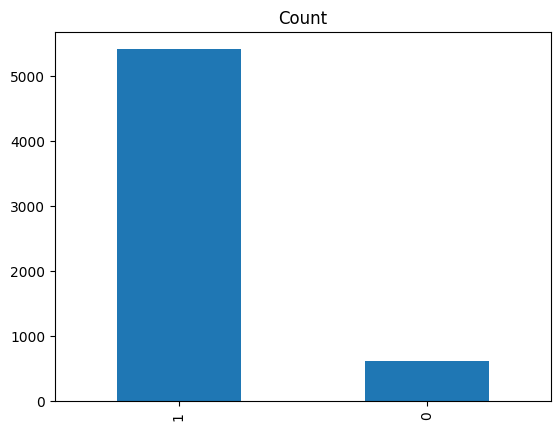

In [58]:
count = df_scv.id.value_counts()
print('MEL 0:', count[0])
print('NV  1:', count[1])
print('Proportion:', round(count[0] / count[1], 2), ': 1')

count.plot(kind='bar', title='Count');

In [59]:
num_images=df_scv['image'].shape
num_images

(6017,)

In [60]:
# Class count
count_class_1, count_class_0 = df_scv.id.value_counts()

# Divide by class
df_class_0 = df_scv[df_scv['id'] == 0]
df_class_1 = df_scv[df_scv['id'] == 1]

In [61]:
df_class_0=df_class_0.drop(columns="Unnamed: 0")

In [62]:
df_class_1=df_class_1.drop(columns="Unnamed: 0")

### Random Under-sampling

Random over-sampling:
1    614
0    614
Name: id, dtype: int64


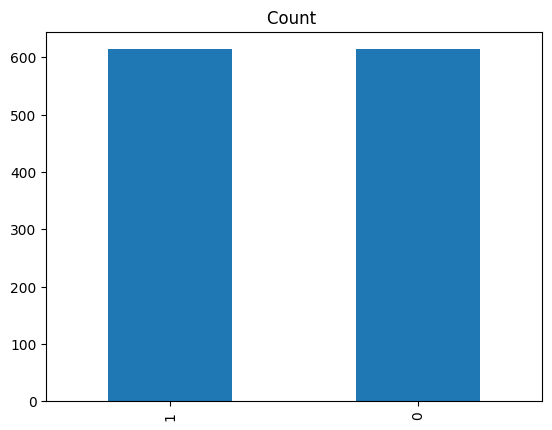

In [63]:
# Random over-sampling
df_class_0_over = df_class_0
df_class_1_under = df_class_1.sample(614, replace=True)

df_over_sampling = pd.concat([df_class_1_under, df_class_0_over],  ignore_index=True,axis=0)

print('Random over-sampling:')
print(df_over_sampling.id.value_counts())

df_over_sampling.id.value_counts().plot(kind='bar', title='Count ');

In [64]:
df_over_sampling

image_id                                              image  id
0     ISIC_0032616  [[[4, 2, 3], [4, 3, 8], [9, 4, 8], [15, 9, 11]...   1
1     ISIC_0026800  [[[244, 157, 174], [238, 154, 167], [240, 157,...   1
2     ISIC_0026007  [[[234, 153, 149], [234, 151, 147], [233, 148,...   1
3     ISIC_0025861  [[[196, 122, 139], [198, 123, 130], [202, 126,...   1
4     ISIC_0028483  [[[230, 153, 159], [230, 152, 152], [215, 132,...   1
...            ...                                                ...  ..
1223  ISIC_0028493  [[[185, 155, 155], [184, 154, 154], [192, 158,...   0
1224  ISIC_0028968  [[[217, 184, 179], [210, 172, 171], [210, 172,...   0
1225  ISIC_0032389  [[[117, 80, 88], [118, 82, 92], [120, 82, 93],...   0
1226  ISIC_0025500  [[[163, 138, 133], [161, 131, 129], [165, 134,...   0
1227  ISIC_0032985  [[[244, 231, 241], [246, 237, 254], [250, 233,...   0

[1228 rows x 3 columns]

In [65]:
# Store number of images in the dataset
num_images = df_over_sampling.shape[0]
num_classes = 2
print(num_images)

1228


In [66]:
# Get y, a vector containing the classes for each image
y = df_over_sampling.pop('id')

In [67]:
y

0       1
1       1
2       1
3       1
4       1
       ..
1223    0
1224    0
1225    0
1226    0
1227    0
Name: id, Length: 1228, dtype: int64

In [68]:
# Allocate space for all images
X = np.empty((num_images, 224, 224, 3),dtype='uint8')

In [69]:
for i in range(0, num_images):
      
    X[i, :, :, :] = np.reshape(df_over_sampling['image'][i], (224, 224, 3)) 

print(y[:].value_counts())

print("X.shape =", X.shape)
print("y.shape =", y.shape)

1    614
0    614
Name: id, dtype: int64
X.shape = (1228, 224, 224, 3)
y.shape = (1228,)


In [70]:
df_over_sampling['image'][0].shape

(224, 224, 3)

In [71]:
X.shape, y.shape

((1228, 224, 224, 3), (1228,))

### Visualize some images / labels for each classes.

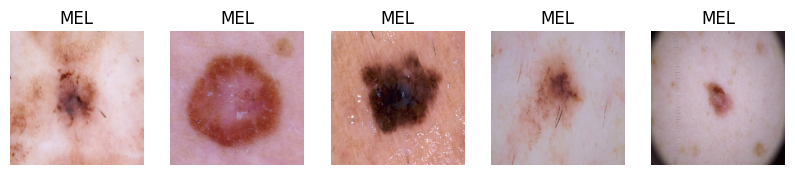

In [72]:
# visualize some images / labels
class_names = ['MEL', 'NV']

W_grid=5
L_grid=1
fig,axes = plt.subplots(L_grid,W_grid,figsize=(10,10))
axes=axes.ravel()
n_training=len(X)
for i in np.arange(0,L_grid * W_grid):
    index=np.random.randint(0,n_training) #Pick a random number 
    axes[i].imshow(X[index])
#     print(y_train[index].tolist())
    axes[i].set_title(class_names[y[index]]) #Prints labels on top of the picture
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

### Split datasets to train and test.

In [73]:
## split train / test

# indices_train, indices_test = train_test_split(list(range(X.shape[0])), train_size=0.8, test_size=0.2, random_state=28)

# x_train = X[indices_train]
# y_train = y[indices_train]
# x_test = X[indices_test]
# y_test = y[indices_test]

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.10,random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.112,random_state=28)


print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)


(981, 224, 224, 3) (981,)
(123, 224, 224, 3) (123,)
(124, 224, 224, 3) (124,)


### Label Encoding & Augmentation.

In [74]:
n_classes=2
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)
y_val = keras.utils.to_categorical(y_val , n_classes)

y_train.shape, y_test.shape, y_val.shape

((981, 2), (123, 2), (124, 2))

In [75]:
# list(y_test)

In [76]:
## to image data generator

datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)

datagen_val = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

## Hyperparameter Tuning (Bayesian optimization using Gaussian Processes.)

In [77]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import keras.backend as K

# space = [Real(1e-6, 0.01, "log-uniform", name='learning_rate'),
#           Real(0.1, 0.8, name='dropout'),
#           Real(0.8, 1.0, name='momentum'),
#           Real(0.9, 1.0, name='beta_1'),
#           Real(0.99, 1.0, name='beta_2'),
#           Integer(low=1,high=100, name = 'epochs'),
#           Integer(low=50, high=225, name='num_dense_nodes'),
#           Categorical(categories=['SGD', 'Adam'],
#                              name='optimizer_type')
#           ]

In [78]:
from keras.optimizers import Adam, SGD

W=224
H=224

def make_model(learning_rate, dropout, momentum, beta_1, beta_2,
               num_dense_nodes, optimizer_type):
    """build model function"""
    print("Start MK")
    # Xception
    input_tensor = Input(shape=(W, H, 3)) # To change input shape
    inception = InceptionV3(
        include_top=False,                # To change output shape
        weights='imagenet',               # Use pre-trained model
        input_tensor=input_tensor,        # Change input shape for this task
    )
    
    # frozen weights
    for layer in inception.layers[:-10]:
        layer.trainable = True  # If Batch Normalization layer, it should be trainable

    # Add extra dense layers
    x = inception.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_dense_nodes, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(rate=dropout)(x)
    predictions = Dense(n_classes, activation='sigmoid')(x)
    model = Model(inputs=inception.input, outputs=predictions)
    
    if optimizer_type == "Adam":
        optimizer = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2)
    elif optimizer_type == "SGD":
        optimizer = SGD(lr=learning_rate, momentum=momentum)

    model.compile(loss='binary_crossentropy',
          optimizer=optimizer,
          metrics=['accuracy'])
    return model

In [79]:
model = make_model(learning_rate=1.3e-04, 
                         dropout=0.5533474631050721, 
                         momentum=0.9, 
                         beta_1=0.999, beta_2=0.999,
                         num_dense_nodes=171, 
                         optimizer_type='Adam')




history=model.fit_generator(
        datagen_train.flow(x_train, y_train, batch_size=32),
        epochs=54,
        steps_per_epoch = int( np.ceil(x_train.shape[0] / 32) ),  
        validation_data=datagen_val.flow(x_val, y_val, batch_size=32))

Start MK
Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/54
31/31 [==============================] - 267s 8s/step - batch: 15.0000 - size: 31.6452 - loss: 0.5018 - accuracy: 0.7380 - val_loss: 0.7120 - val_accuracy: 0.7097
Epoch 2/54
31/31 [==============================] - 229s 7s/step - batch: 15.0000 - size: 31.6452 - loss: 0.3428 - accuracy: 0.8609 - val_loss: 0.4856 - val_accuracy: 0.8145
Epoch 3/54
31/31 [==============================] - 227s 7s/step - batch: 15.0000 - size: 31.6452 - loss: 0.2706 - accuracy: 0.8904 - val_loss: 0.5368 - val_accuracy: 0.8468
Epoch 4/54
31/31 [==============================] - 227s 7s/step - batch: 15.0000 - size: 31.6452 - loss: 0.2463 - accuracy: 0.9006 - val_loss: 0.5765 - val_accuracy: 0.8306
Epoch 5/54
31/31 [==============================] - 226s 7s/step - batch: 15.0000 - size: 31.6452 - loss: 0.1918 - accuracy: 0.9256 - val_loss: 0.7555 - val_accuracy: 0.8266
Epoch 6/54
31/31 [==============================]

Epoch 46/54
31/31 [==============================] - 260s 8s/step - batch: 15.0000 - size: 31.6452 - loss: 0.0402 - accuracy: 0.9898 - val_loss: 1.1887 - val_accuracy: 0.8790
Epoch 47/54
31/31 [==============================] - 250s 8s/step - batch: 15.0000 - size: 31.6452 - loss: 0.0294 - accuracy: 0.9939 - val_loss: 1.0346 - val_accuracy: 0.8871
Epoch 48/54
31/31 [==============================] - 253s 8s/step - batch: 15.0000 - size: 31.6452 - loss: 0.0070 - accuracy: 0.9959 - val_loss: 0.8303 - val_accuracy: 0.8952
Epoch 49/54
31/31 [==============================] - 259s 8s/step - batch: 15.0000 - size: 31.6452 - loss: 0.0044 - accuracy: 0.9995 - val_loss: 0.7466 - val_accuracy: 0.8952
Epoch 50/54
31/31 [==============================] - 259s 8s/step - batch: 15.0000 - size: 31.6452 - loss: 0.0215 - accuracy: 0.9959 - val_loss: 0.7388 - val_accuracy: 0.8871
Epoch 51/54
31/31 [==============================] - 279s 9s/step - batch: 15.0000 - size: 31.6452 - loss: 0.0215 - accuracy:

 ### Analysis training and validation results

In [80]:
label_to_class = {
    'Mel': 0,
    'Nv' : 1}

In [81]:
class_to_label = {v: k for k, v in label_to_class.items()}

### Load saved  best model

In [82]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

 batch_normalization_99 (BatchN  (None, 25, 25, 64)  192         ['conv2d_99[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_101 (Batch  (None, 25, 25, 64)  192         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 25, 25, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 25, 25, 32)  96          ['conv2d_105[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_116 (Batch  (None, 25, 25, 64)  192         ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_116[0][0]']
                                                                                                  
 conv2d_114 (Conv2D)            (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 25, 25, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_128 (Conv2D)            (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 12, 12, 128)  384        ['conv2d_128[0][0]']             
 Normaliza

                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 12, 12, 160)  480        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_138[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_149 (Batch  (None, 12, 12, 160)  480        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_149[0][0]']
          

                                                                                                  
 batch_normalization_159 (Batch  (None, 12, 12, 192)  576        ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_159[0][0]']
                                                                                                  
 conv2d_155 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_159[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_164 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_164 (Batch  (None, 12, 12, 192)  576        ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 12, 12, 192)  576        ['conv2d_168[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_170 (Batch  (None, 5, 5, 320)   960         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_172[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_177[0][0]']
          

                                                                                                  
 activation_185 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_185[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 batch_normalization_187 (Batch  (None, 5, 5, 192)   576         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 5, 5, 320)    0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 

 #### confusion matrix

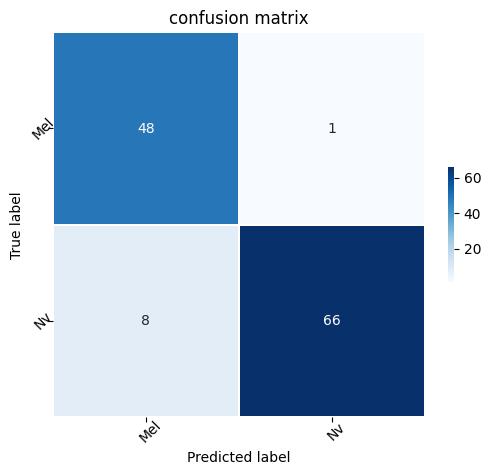

In [83]:
## plot confusion matrix

x = preprocess_input(copy.deepcopy(x_test))
y_preds = model.predict(x)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(6, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [84]:
model_path = os.path.join('D:\\FYP\\new implementaion cnn\\','InceptionTrainingBN.h5')
model.save(model_path)

#### classification report

In [85]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import tensorflow as tf

In [86]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_trues, y_preds) * 100))

Accuracy: 92.68%


In [87]:
print(classification_report(y_trues, y_preds))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91        49
           1       0.99      0.89      0.94        74

    accuracy                           0.93       123
   macro avg       0.92      0.94      0.93       123
weighted avg       0.93      0.93      0.93       123



In [88]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

total=sum(sum(cm))
#####from confusion matrix calculate accuracy
accuracy=(cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity)

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity)


Accuracy :  0.926829268292683
Sensitivity :  0.9795918367346939
Specificity :  0.8918918918918919


### Graphing our training and validation

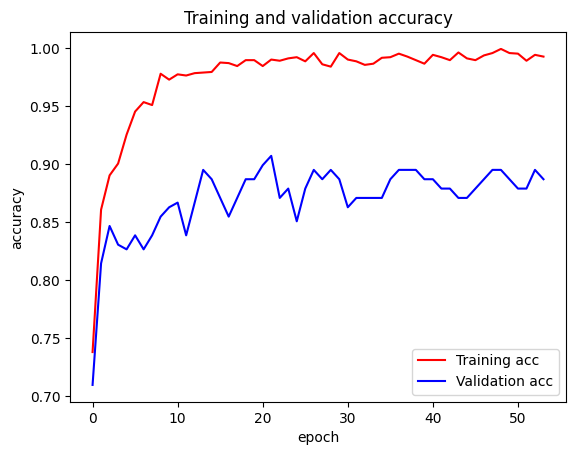

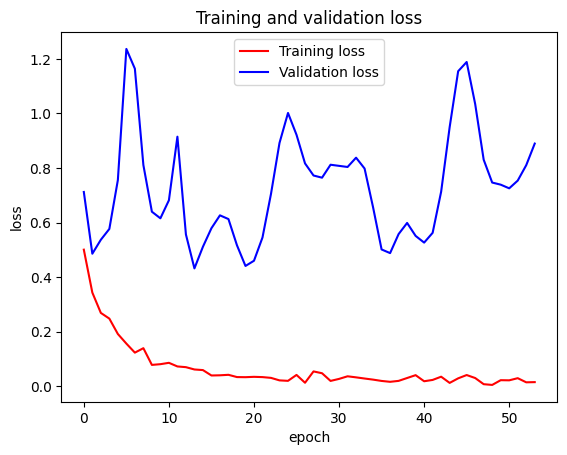

In [89]:
# history=best_history_2
# history.history.keys()

#Graphing our training and validation
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

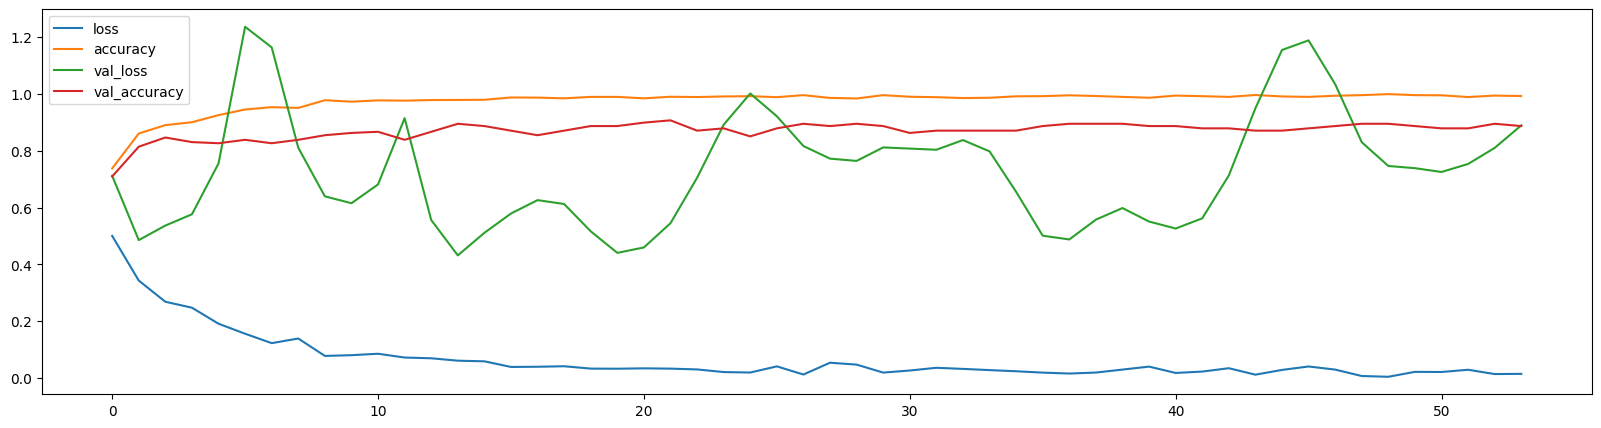

In [90]:
pd.DataFrame(history.history).plot(figsize=(20,5))
plt.show()

##### ROC and AUC

In [91]:
from tqdm import tqdm
import gc
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(datagen_test.flow(x_test, batch_size=32, shuffle=False),steps = len(x_test)/32)    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:26<00:00,  8.61s/it]


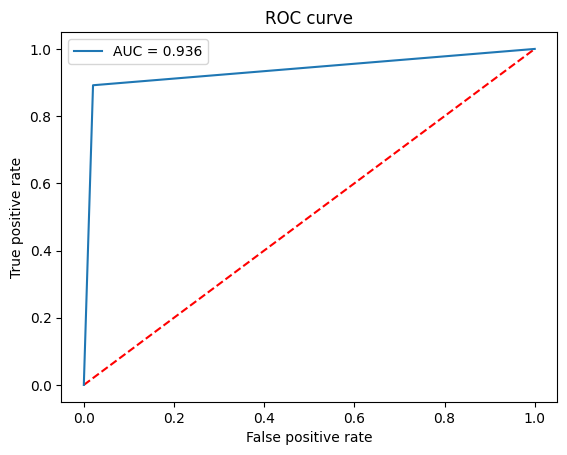

In [92]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

 #### Save Model

 #### Prediction using Xception

#### Implement Grad-CAM, Grad-CAM++ .First, implement the function to superimpose original image and heatmap of each cams.

In [93]:
from tensorflow.python.framework.ops import disable_eager_execution

In [94]:
def superimpose(img, cam):
    """superimpose original image and cam heatmap"""
    
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + img * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return img, heatmap, superimposed_img

In [95]:
def _plot(model, cam_func, img, cls_true):
    """plot original image, heatmap from cam and superimpose image"""
    original_img=img
    # for cam
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(copy.deepcopy(x))

    # for superimpose
    img = np.uint8(img)

    # cam / superimpose
    cls_pred, cam = cam_func(model=model, x=x, layer_name=model.layers[-2].name)
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=2, figsize=(9, 4))

    axs[0].imshow(original_img)
    axs[0].set_title('original image')
    axs[0].axis('off')

    axs[1].imshow(superimposed_img)
    axs[1].set_title('superimposed image')
    axs[1].axis('off')

#     axs[2].imshow(superimposed_img)
#     axs[2].set_title('superimposed image')
#     axs[2].axis('off')

    plt.suptitle('True label: ' + class_to_label[cls_true] + ' / Predicted label : ' + class_to_label[cls_pred])
    plt.tight_layout()
    plt.show()

#### Grad-CAM:


In [96]:
## Grad-CAM function

def grad_cam(model, x, layer_name):
    """Grad-CAM function"""
    
    cls = np.argmax(model.predict(x))
    
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    disable_eager_execution()
    grads = K.gradients(y_c, conv_output)[0]

    # Get outputs and grads
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([x])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    
    weights = np.mean(grads_val, axis=(0, 1)) # Passing through GlobalAveragePooling

    cam = np.dot(output, weights) # multiply
    cam = np.maximum(cam, 0)      # Passing through ReLU
    cam /= np.max(cam)            # scale 0 to 1.0

    return cls, cam

#### Grad-CAM++:

In [97]:
## Grad-CAM++ function

def grad_cam_plus_plus(model, x, layer_name):
    """Grad-CAM++ function"""
    
    cls = np.argmax(model.predict(x))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    first = K.exp(y_c) * grads
    second = K.exp(y_c) * grads * grads
    third = K.exp(y_c) * grads * grads * grads 

    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([x])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1, 1, conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom # 0


    weights = np.maximum(conv_first_grad[0], 0.0)    
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0), axis=0) 
    alphas /= alpha_normalization_constant.reshape((1, 1, conv_first_grad[0].shape[2])) 
    
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad[0].shape[2])), axis=0)
    cam = np.sum(deep_linearization_weights * conv_output[0], axis=2)
    cam = np.maximum(cam, 0) # Passing through ReLU
    cam /= np.max(cam)       # scale 0 to 1.0  


    return cls, cam

### Compare each visual methods. 

In [98]:
## compare Grad-CAM / Grad-CAM++ 

def _compare(model, layer_name, target_cls):
    """compare Grad-CAM / Grad-CAM++  on target class images"""
    
    indices = np.where(y == target_cls)[0]
    label = class_to_label[target_cls]

    n_cols = 10 # # of sample plot

    fig, axs = plt.subplots(ncols=n_cols, nrows=3, figsize=(25, 9))

    for i in range(n_cols):
        
        img = X[indices[i]]
        # for cam
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(copy.deepcopy(x))

        # original
        axs[0, i].imshow(np.uint8(img))
        axs[0, i].set_title(str(indices[i])+' '+label)
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        if i == 0:
            axs[0, i].set_ylabel('Original', rotation=0, ha='right')

        # Grad-CAM
        cls_pred, cam = grad_cam(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam = superimpose(img, cam)
        axs[1, i].imshow(img_grad_cam)
        axs[1, i].set_title('pred: ' + class_to_label[cls_pred])
        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])
        if i == 0:
            axs[1, i].set_ylabel('Grad-CAM', rotation=0, ha='right')

        # Grad-CAM++
        cls_pred, cam = grad_cam_plus_plus(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam_plus_plus = superimpose(img, cam)
        axs[2, i].imshow(img_grad_cam_plus_plus)
        axs[2, i].set_title('pred: ' + class_to_label[cls_pred])
        axs[2, i].set_xticks([])
        axs[2, i].set_yticks([])
        if i == 0:
            axs[2, i].set_ylabel('Grad-CAM++', rotation=0, ha='right')



    plt.show()

In [99]:
## compare Grad-CAM / Grad-CAM++ 

def _compare_an_image(model,img, layer_name):
    """compare Grad-CAM / Grad-CAM++  on target class images"""
    
#     indices = np.where(y == target_cls)[0]
#     label = class_to_label[target_cls]

    n_rows = 1 # # of sample plot

    fig, axs = plt.subplots(ncols=3, nrows=n_rows, figsize=(10, 9))

    for i in range(n_rows):
        
#         original_img = img
#         img=np.uint8(img)
        # for cam        
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(copy.deepcopy(x))

        # original
        axs[0].imshow(np.uint8(img))
        axs[0].set_title('Input image')
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        if i == 0:
            axs[0].set_xlabel('Original')

        # Grad-CAM
        cls_pred, cam = grad_cam(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam = superimpose(img, cam)
        axs[1].imshow(img_grad_cam)
        axs[1].set_title('pred: ' + class_to_label[cls_pred])
        axs[1].set_xticks([])
        axs[1].set_yticks([])
        if i == 0:
            axs[1].set_xlabel('Grad-CAM')

        # Grad-CAM++
        cls_pred, cam = grad_cam_plus_plus(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam_plus_plus = superimpose(img, cam)
        axs[2].imshow(img_grad_cam_plus_plus)
        axs[2].set_title('pred: ' + class_to_label[cls_pred])
        axs[2].set_xticks([])
        axs[2].set_yticks([])
        if i == 0:
            axs[2].set_xlabel('Grad-CAM++')



    plt.show()

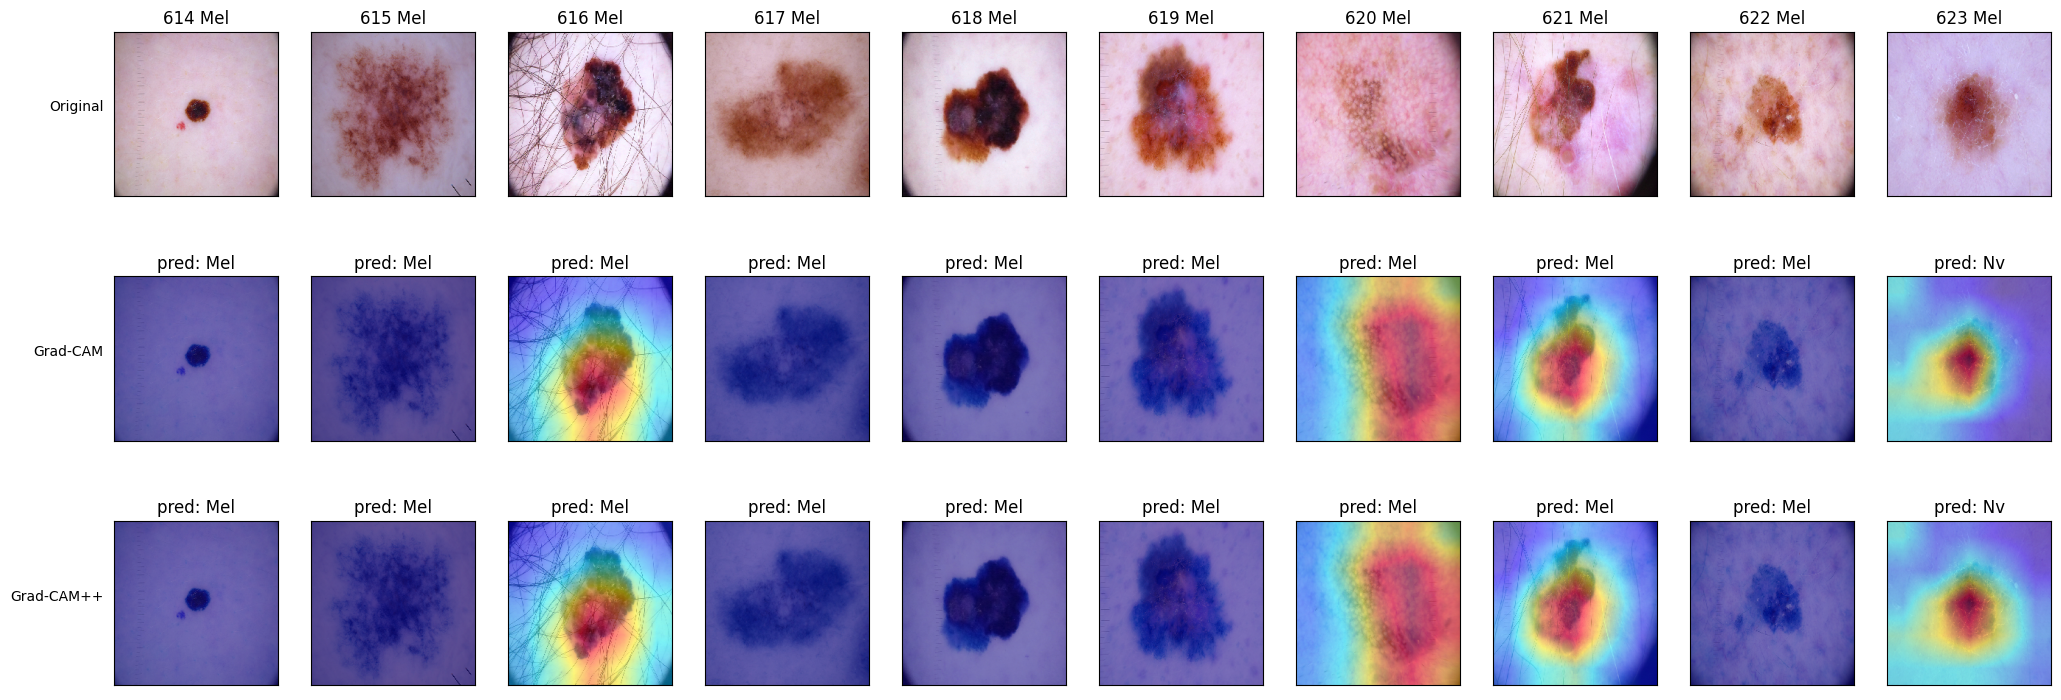

In [100]:
# ## mel
_compare(model=model, layer_name=model.layers[-5].name, target_cls=0)

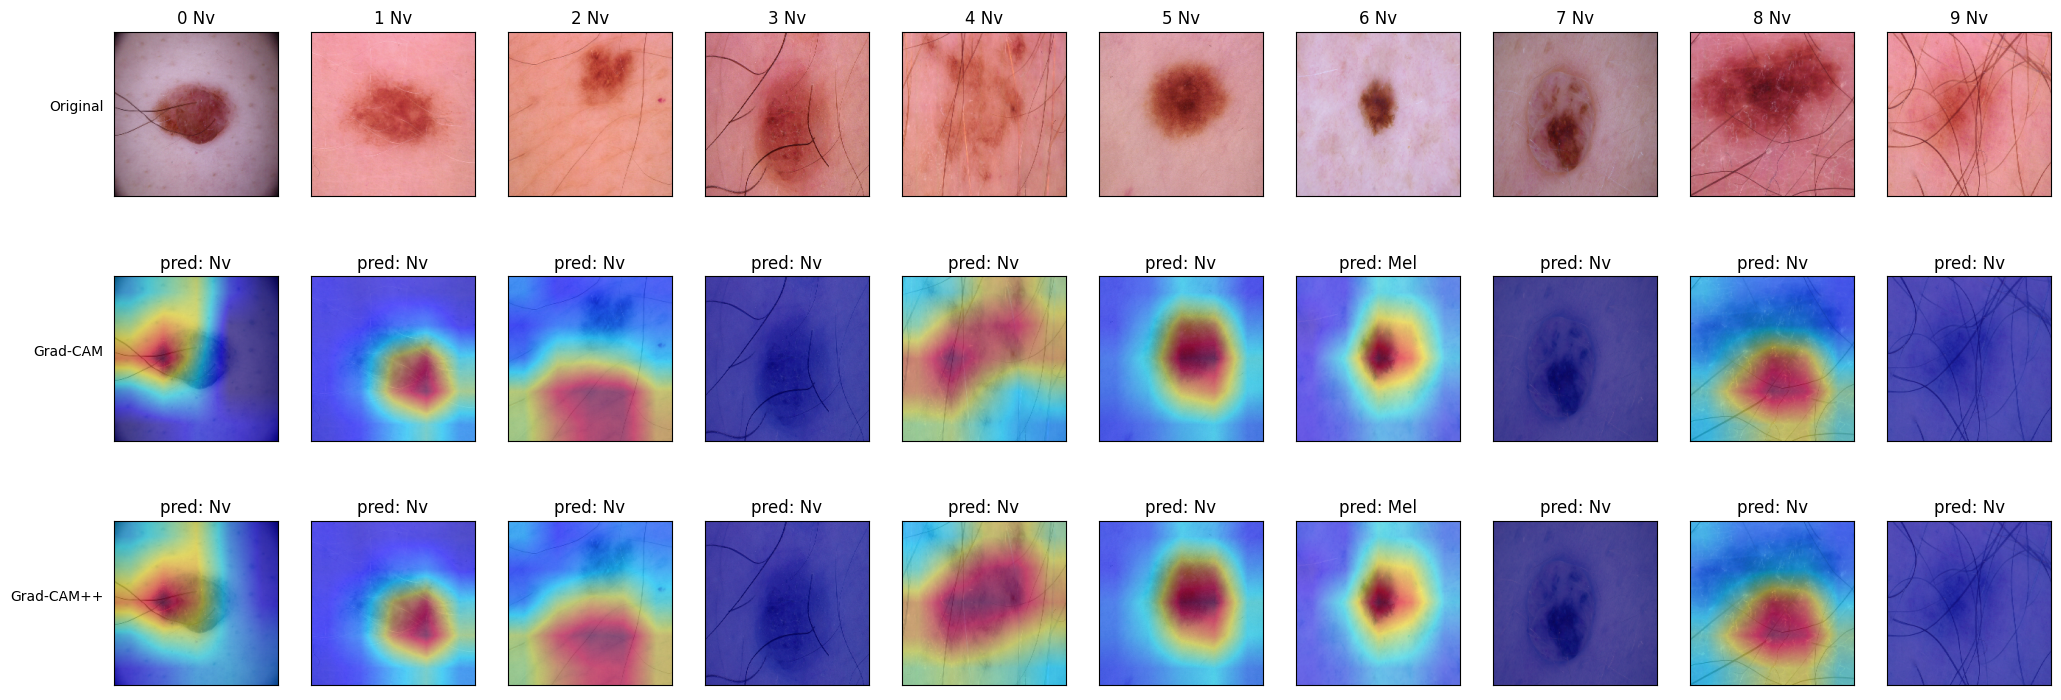

In [101]:
## nv
_compare(model=model, layer_name=model.layers[-5].name, target_cls=1)

In [ ]:
# pathf1='ISIC_0000029.JPG'
# pathf1='ISIC_0000024.JPG'
# pathf1='ISIC_0000034.JPG'
# pathf1='ISIC_0000006.JPG'
# pathf1='ISIC_0000046.JPG'
# pathf1='ISIC_0000049.JPG'
# Grad Cam better
# pathf1='ISIC_0000067.JPG'
# pathf1='ISIC_0000367.JPG'
# pathf1='ISIC_0000403.JPG'

#### For an Image

In [793]:
from PIL import Image

pathf1='ISIC_0000409.JPG'
# pathf1='ISIC_0000365.JPG'
# pathf1='ISIC_0000382.JPG'
# pathf1='ISIC_0000416.JPG'
# pathf1='ISIC_0000521.JPG'

pathf2=pathf1.split('.')[0]+'_attribute_pigment_network.PNG'
pathf3=pathf1.split('.')[0]+'_attribute_negative_network.PNG'
pathf4=pathf1.split('.')[0]+'_attribute_globules.PNG'
pathf5=pathf1.split('.')[0]+'_attribute_streaks.PNG'
pathf6=pathf1.split('.')[0]+'_attribute_milia_like_cyst.PNG'

img = np.array(load_img(pathf1,target_size=(224,224,3)),dtype=np.float64)
img2 = np.array(load_img(pathf2,target_size=(224,224)),dtype=np.float64)
img3 = np.array(load_img(pathf3,target_size=(224,224)),dtype=np.float64)
img4 = np.array(load_img(pathf4,target_size=(224,224)),dtype=np.float64)
img5 = np.array(load_img(pathf5,target_size=(224,224)),dtype=np.float64)
img6 = np.array(load_img(pathf6,target_size=(224,224)),dtype=np.float64)
# # img = np.expand_dims(img,axis=0)
# img = preprocess_input(img)
# img=img/255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


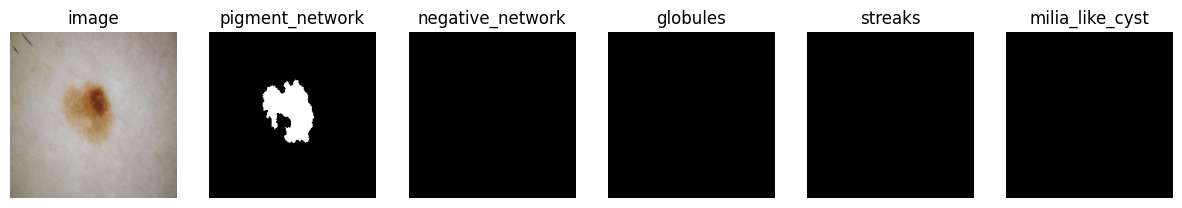

In [794]:
W_grid=6
L_grid=1
fig,axes = plt.subplots(L_grid,W_grid,figsize=(15,15))
axes=axes.ravel()

# index=np.random.randint(0,n_training) #Pick a random number 
axes[0].imshow(img/255)
axes[0].set_title("image") #Prints labels on top of the picture
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title("pigment_network") #Prints labels on top of the picture
axes[1].axis('off')
plt.subplots_adjust(hspace=0.5)

axes[2].imshow(img3)
axes[2].set_title("negative_network") #Prints labels on top of the picture
axes[2].axis('off')
plt.subplots_adjust(hspace=0.5)

axes[3].imshow(img4)
axes[3].set_title("globules") #Prints labels on top of the picture
axes[3].axis('off')
plt.subplots_adjust(hspace=0.5)

axes[4].imshow(img5)
axes[4].set_title("streaks") #Prints labels on top of the picture
axes[4].axis('off')
plt.subplots_adjust(hspace=0.5)

axes[5].imshow(img6)
axes[5].set_title("milia_like_cyst") #Prints labels on top of the picture
axes[5].axis('off')
plt.subplots_adjust(hspace=0.5)

In [785]:
# grad_cam and  grad_cam_plus_plus for the input image

In [54]:
# ISIC_0000409
_compare_an_image(model,img,model.layers[-5].name)